In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme('paper',style='white',font_scale=1.25)
import math
import random
import matplotlib
from os.path import join,exists
import os
from os import mkdir
import cv2

In [37]:
def plotter(data_in,x_data,y_data,x_label,y_label,ax_in,letter,scientific = False,ylim=False,f_s=24):
    sns.swarmplot(ax = ax_in,x=x_data,y=y_data,data=data_in,size=5,color='black',alpha=0.5)
    sns.boxplot(ax = ax_in,x=x_data,y=y_data,data=data_in,color = "white", showmeans = True,meanprops={
                        "marker":"s",
                        "markerfacecolor":"red", 
                        "markeredgecolor":"red",
                        "markersize":"7",
                        "alpha":1.0})
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    #ax_in.text(-0.1, 1.15, letter, transform=ax_in.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
    ax_in.tick_params(labelsize=9)
    if scientific:    
        ax_in.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
    if ylim:
        ax_in.set_ylim(ylim)
    return ax_in  

#plots macro phi
def plot_macro_phi(data,ax_in,letter,x_label,y_label,vline=True,log=False,ae=True):
    sns.lineplot(ax = ax_in, data=data,x='Time (min)',y='Phase Shift Angle (Pa)',hue='concentration %',
                palette=sns.color_palette('bright',data['concentration %'].unique().shape[0]))
    ax_in.text(-0.1, 1.15, letter, transform=ax_in.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
    ax_in.set_xlabel(x_label, fontsize=12)
    ax_in.set_ylabel(y_label, fontsize=12)
    ax_in.tick_params(labelsize=9)
    ax_in.set_xlim([0,90])
    if vline:
        ax_in.axvline(50,color='black',linestyle='--')
    if log:
        ax_in.set_yscale('log')
        ax_in.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax_in.ticklabel_format(axis='y',style='plain', scilimits=(0,0))
        ax_in.yaxis.major.formatter._useMathText = True
        ax_in.legend(title = r"Concentration [$\%$]",loc='upper left',fontsize = 9)
    if ae:
        plt.ylim([0,10])
        
    return ax_in

In [5]:
data_folder = '/home/lab/projects/microrheology'
Calib_100 = pd.read_csv(os.path.join(data_folder,"microdata/Calibration_100_track_ID_summary.csv"))
Calib_30 = pd.read_csv(os.path.join(data_folder,"microdata/Calibration_30_track_ID_summary.csv"))
Calib_100["loss_tan"] = np.tan(Calib_100["phi_(rad)"])
Calib_30["loss_tan"] = np.tan(Calib_30["phi_(rad)"]) 
Calib_30['rr'] = Calib_30['radius_(m)']**2

In [6]:
from glob import glob

In [7]:
def get(path,ii):
    res2 = []
    for i in glob(f'/mnt/c/Users/pokkilab/Downloads/Amplitude_comp/{path}/*'):
        r = pd.read_csv(os.path.join(i,'resa2.csv'))
        r['location'] = os.path.split(i)[-1].split('_')[0][-2:]
        res2.append(r)
    res2 = pd.concat(res2)
    grouped = res2.groupby(['location','track_id']).mean().reset_index(drop=False)
    grouped['current'] = ii
    grouped['rr'] = grouped['radius_(m)']**2
    return grouped

def get2(path,ii):
    res2 = []
    for i in glob(f'/mnt/g/arttu/065calibration221115/221115/*'):
        r = pd.read_csv(os.path.join(i,'resa2.csv'))
        r['location'] = os.path.split(i)[-1].split('_')[0][-2:]
        res2.append(r)
    res2 = pd.concat(res2)
    grouped = res2.groupby(['location','track_id']).mean().reset_index(drop=False)
    grouped['current'] = ii
    grouped['rr'] = grouped['radius_(m)']**2
    return grouped

In [8]:
a1 = get('1_25/1_25',1.25)
a2 = get2('0_625',0.65)
a3 = get('1_00',1.00)
all_data = pd.concat([a1,a2,a3])

In [9]:
#all_data.to_csv('/mnt/c/Users/pokkilab/Downloads/kalirointifaili.csv')

In [10]:
res2 = []
for i in glob(f'/mnt/g/arttu/NH2_100_um/NH2_100_um/21*/21*'):
    r = pd.read_csv(os.path.join(i,'resa2.csv'))
    r['location'] = os.path.split(i)[-1].split('_')[0][-2:]
    res2.append(r)
res2 = pd.concat(res2)
grouped = res2.groupby(['location','track_id']).mean().reset_index(drop=False)
grouped['current'] = 1.26
grouped['rr'] = grouped['radius_(m)']**2
a4 = grouped

In [11]:
all_data = pd.concat([a1,a2,a3,a4])

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
from sklearn import linear_model

In [14]:
T = 25
T_0 = 25
r_T_0 = 0.971e3
#v = 1026.16e-6
v = 30000e-6
a = 9.2e-4
b = 4.5e-7
r = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
nn = v*r

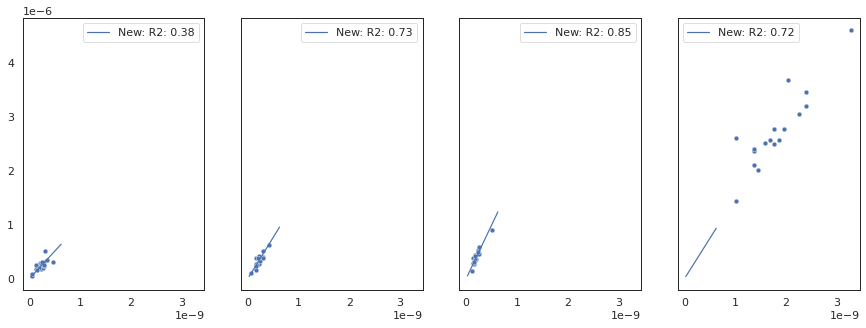

In [15]:
fig,ax = plt.subplots(1,4,figsize=(15,5),sharey=True,sharex=True)
outs_ = []
outs2_ = []
outs3_ = []
orig_ = []
for ii,(index,i) in enumerate(all_data.groupby('current')):
    if ii==4:
        break
    X = i['rr'].values.reshape((-1,1))
    y = i['v_fit'].values
    sns.scatterplot(x=X[...,0],y=y,ax=ax[ii])
    reg = linear_model.LinearRegression(fit_intercept=False).fit(X, y)
    X_ = np.linspace(5e-6**2,25e-6**2)[...,None]
    preds = reg.predict(X_)
    sns.lineplot(x=X_[...,0],y=preds,ax=ax[ii],label=f'New: R2: {np.round(reg.score(X, y),2)}')
    p = reg.predict(X)
    #ax[ii].set_title(f'{index}')
    outs_.append(p)
    outs2_.append(6*np.pi*nn*X[:,0]*p/(4/3*np.pi*X[:,0]**3))
    X = i['rr'].values.reshape((-1,1))
    y = i['v_fit'].values
    reg2_ = linear_model.LinearRegression(fit_intercept=False).fit(X, y)
    outs3_.append(4.5*nn*reg2_.coef_[0])
    #outs2.append(6*np.pi*nn*X[:,0]*i['v_fit'].values/(4/3*np.pi*X[:,0]**3))
    orig_.append(i['F_V_fit'].values)

In [16]:
from cmdstanpy import CmdStanModel
import os
import json
import arviz as az

In [17]:

Xs = []
ys = []
raws = []
for ii,(index,i) in enumerate(all_data.groupby('current')):
    print(index)
    if ii==6:
        break
    Xs.append(i['rr'].values.reshape((-1,1)))
    ys.append(i['v_fit'].values)
    raws.append(i['F_V_fit'].values)

0.65
1.0
1.25
1.26


In [18]:
def gen_hats(X,y,x_preds):
    
    x_ = np.concatenate([X[:,0],x_preds])
    train = np.arange(X[:,0].shape[0])+1
    test = np.max(train)+np.arange(x_preds.shape[0])+1
    linear_data = {
        'N':X.shape[0],
        'N_pred': x_preds.shape[0],
        'x': x_.tolist(),
        'y': (y).tolist(),
        'train': train.tolist(),
        'test': test.tolist()

    }
    with open('data.json','w') as f:
        json.dump(linear_data,f)

    model = CmdStanModel(stan_file='linear_2.stan')
    fit = model.sample(data='data.json',
                       adapt_delta=0.85,max_treedepth=20,iter_sampling=2000)
    print(fit.diagnose())
    
    return fit.draws_pd()

In [19]:
x_preds = np.linspace(3e-6**2,35e-6**2,200)
y_hats_065 = gen_hats(Xs[0],ys[0],x_preds)
y_hats_100 = gen_hats(Xs[1],ys[1],x_preds)
y_hats_125 = gen_hats(Xs[2],ys[2],x_preds)
x_preds2 = np.linspace(Xs[-1].min()-0.5e-9,Xs[-1].max()+0.3e-9,200)
y_hats_big_man = gen_hats(Xs[-1],ys[-1],x_preds2)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpm02vmj1k/linear_2-20221221113050_1.csv, /tmp/tmpm02vmj1k/linear_2-20221221113050_2.csv, /tmp/tmpm02vmj1k/linear_2-20221221113050_3.csv, /tmp/tmpm02vmj1k/linear_2-20221221113050_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpm02vmj1k/linear_2-20221221113052_1.csv, /tmp/tmpm02vmj1k/linear_2-20221221113052_2.csv, /tmp/tmpm02vmj1k/linear_2-20221221113052_3.csv, /tmp/tmpm02vmj1k/linear_2-20221221113052_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpm02vmj1k/linear_2-20221221113054_1.csv, /tmp/tmpm02vmj1k/linear_2-20221221113054_2.csv, /tmp/tmpm02vmj1k/linear_2-20221221113054_3.csv, /tmp/tmpm02vmj1k/linear_2-20221221113054_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpm02vmj1k/linear_2-20221221113056_1.csv, /tmp/tmpm02vmj1k/linear_2-20221221113056_2.csv, /tmp/tmpm02vmj1k/linear_2-20221221113056_3.csv, /tmp/tmpm02vmj1k/linear_2-20221221113056_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [20]:
y1 = y_hats_065['beta_scaled'].values*9/2*nn
y2 = y_hats_100['beta_scaled'].values*9/2*nn
y3 = y_hats_125['beta_scaled'].values*9/2*nn
y4 = y_hats_big_man['beta_scaled'].values*9/2*nn
df = pd.DataFrame({'F/V': np.concatenate([y1,y2,y3,y4]),
                   'current':[*[r'30 $\mu$m/0.65A']*y_hats_065.shape[0],
                              *[r'30 $\mu$m/1.0A']*y_hats_100.shape[0],
                              *[r'30 $\mu$m/1.25A']*y_hats_125.shape[0],
                               *[r'100 $\mu$m/1.25A']*y_hats_big_man.shape[0]],
                  'estimate':'model'})

In [21]:
print(int(np.round(y1.mean())),',',int(np.round(y1.std())))
print(int(np.round(y2.mean())),',',int(np.round(y2.std())))
print(int(np.round(y3.mean())),',',int(np.round(y3.std())))
print(int(np.round(y4.mean())),',',int(np.round(y4.std())))

133685 , 10144
200013 , 10710
259159 , 9141
195454 , 6919


In [22]:
y4.std()/y4.mean()*100

3.539906810219336

In [23]:
y3.std()/y3.mean()*100

3.5270620034822224

In [24]:
y2.std()/y2.mean()*100

5.354465107089619

In [25]:
y1.std()/y1.mean()*100

7.58781492229079

In [26]:
def calib_get(i):
    print(Calib_30[Calib_30['current']==i]['F_V_fit'].std()/Calib_30[Calib_30['current']==i]['F_V_fit'].mean()*100)

calib_get(0.65)
calib_get(1.)
calib_get(1.25)

39.54846227614618
22.55371222944149
22.083391602651677


In [27]:
def calib_get(i):
    print(Calib_30[Calib_30['current']==i]['F_V_fit'].median(),Calib_30[Calib_30['current']==i]['F_V_fit'].std())

calib_get(0.65)
calib_get(1.)
calib_get(1.25)

138870.3484620526 57991.28291777066
206418.0223384846 46284.79623707474
253659.11599982082 56800.82304715773


In [28]:
Calib_30[Calib_30['current']==1.]['F_V_fit'].std()/Calib_30[Calib_30['current']==1.]['F_V_fit'].mean()*100

22.55371222944149

In [29]:
Calib_30[Calib_30['current']==0.65]['F_V_fit'].std()/Calib_30[Calib_30['current']==0.65]['F_V_fit'].mean()*100

39.54846227614618

In [30]:
np.std(raws[-1])/np.mean(raws[-1])

0.18236134188853728

In [31]:
Xs[-1].min()

1.00614808125e-09

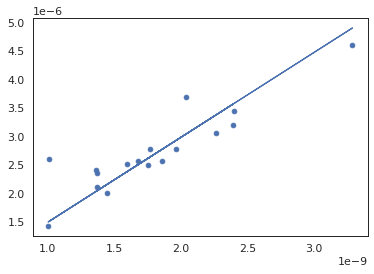

In [32]:
plt.scatter(Xs[-1],ys[-1])
plt.plot(Xs[-1][:,0],y_hats_big_man.filter(regex='beta_scaled').mean().values*Xs[-1][:,0])

In [34]:
def rename(x):
    if x==1.26:
        return r'100 $\mu m$/1.25 A'
    else:
        return r'30 $\mu m$' f'/{x} A'
all_data['current_rename'] = all_data['current'].apply(rename)

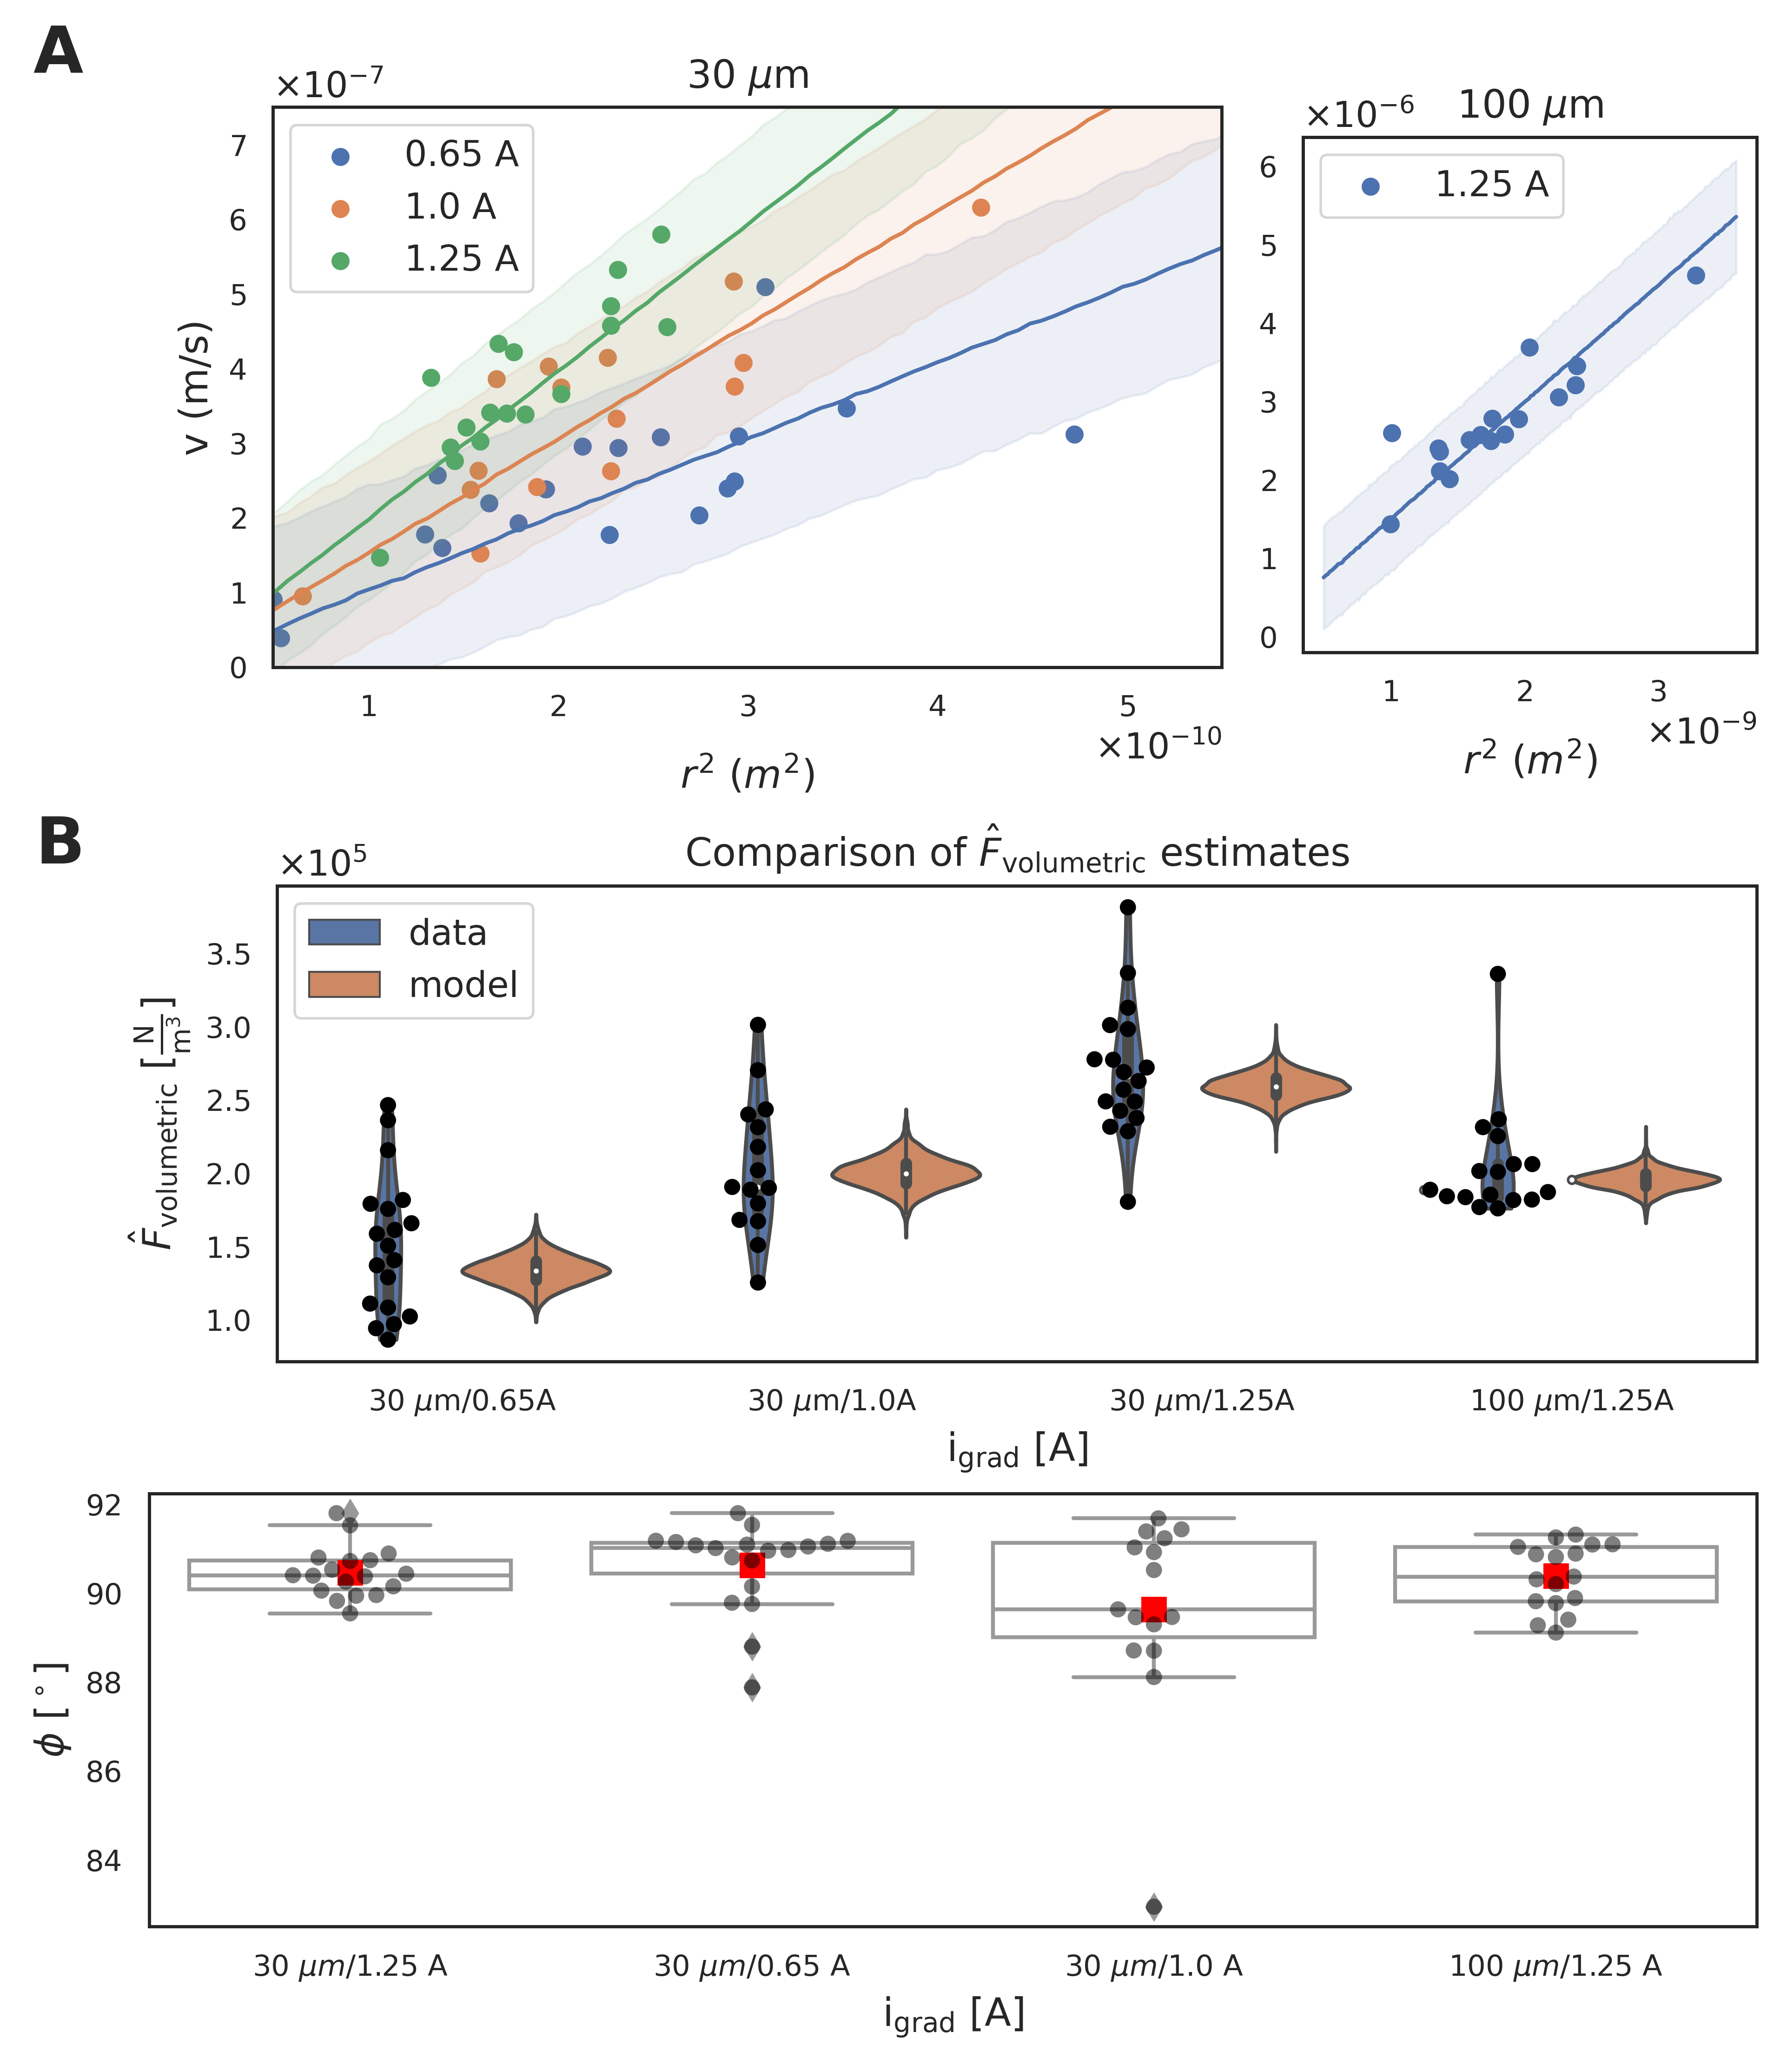

In [38]:
#fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
f_s = 20
fig = plt.figure(figsize=(7.5,8.75),constrained_layout=True,dpi=500)
subfigs = fig.subfigures(3, 1, wspace=0.0,hspace=0., height_ratios=[.35, 0.3,0.25])
currents = [0.65,1.00,1.25,1.25]
subfigs_nest = subfigs[0].subfigures(1, 2, width_ratios=[0.7, 0.3])
ax = subfigs_nest[0].subplots(1, 1,sharey=False)
ax_nest = subfigs_nest[1].subplots(1, 1,sharey=False)
cols = sns.color_palette()[:3]

def hats(hats,i,ra,c,ax):
    y_hats = hats.filter(regex='y_hat')
    up = np.percentile(y_hats,95,axis=0)
    down = np.percentile(y_hats,5,axis=0)
    mean = np.mean(y_hats,axis=0)
    ax.fill_between(ra,down,up,color=c,alpha=0.1)
    ax.plot(ra,mean,color=c,alpha=1.0)
    ax.scatter(Xs[i],ys[i],color=c,label=f'{currents[i]} A')
    ax.set_xlabel('$r^2$ ($m^2$)',labelpad=10)
    #ax.set_title(f'{currents[i]} A')
    r2 = hats['r2'].values

# r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]"
hats(y_hats_065,0,x_preds,cols[0],ax)
hats(y_hats_100,1,x_preds,cols[1],ax)
hats(y_hats_125,2,x_preds,cols[2],ax)

ax.set_title(r'30 $\mu$m')

hats(y_hats_big_man,-1,x_preds2,cols[0],ax_nest)
ax_nest.set_title(r'100 $\mu$m')
ax_nest.legend(loc='upper left')
#r2 = y_hats_big_man['r2'].values
#ax[3].text(1.9e-9,0.8e-6,f'R2:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',
#          bbox=dict(boxstyle="square",
#                   ec=(0., 0., 0.),
#                   fc=(1., 1., 1.)))
ax.set_xlim(0.5e-10,5.5e-10)
ax.set_ylim(0,.75e-6)
ax.tick_params(labelsize=9)
ax_nest.tick_params(labelsize=9)
ax.set_ylabel('v (m/s)')
ax.legend(loc="upper left")
#plt.subplots_adjust(bottom=0.15)
ax2 = subfigs[1].subplots(1, 1)

orig_data = pd.DataFrame({
    'current':[*[r'30 $\mu$m/0.65A']*len(raws[0]),*[r'30 $\mu$m/1.0A']*len(raws[1]),*[r'30 $\mu$m/1.25A']*len(raws[2]),
              *[r'100 $\mu$m/1.25A']*len(raws[3])],
    'F/V':[*raws[0],*raws[1],*raws[2],*raws[3]],
    'estimate':'data'})
comb = pd.concat([orig_data,df])
sns.violinplot(data=comb,x='current',y='F/V',ax=ax2,hue='estimate',cut=0)
sns.swarmplot(data=orig_data,x='current',y='F/V',color='black',ax=ax2)
for item in ax2.collections[12:]:
    item.set_offsets(item.get_offsets() - 0.20)
ax2.set_xlabel("i$_\mathregular{grad}$ [A]")
ax2.set_title('Comparison of $\hat{F}_\mathregular{volumetric}$ estimates')
ax2.set_ylabel(r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]")
ax2.legend(loc='upper left')
ax2.tick_params(labelsize=9)

ax3 = subfigs[2].subplots(1, 1)
all_data['phi_(deg)'] = np.rad2deg(all_data['phi_(rad)'])
#sns.histplot(data=df[df['current']==1.25],x='F/V',ax=ax3,stat='density')
ax3 = plotter(all_data, "current_rename", "phi_(deg)","i$_\mathregular{grad}$ [A]",r"$\phi$ $[^\circ]$",ax3,"C",f_s=f_s)

#ax3.axvline(x=me-st,color='black',linewidth=1,linestyle='--')
#ax3.axvline(x=me+st,color='black',linewidth=1,linestyle='--')

ax.text(-0.2, 1.15, 'A', transform=ax.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
ax2.text(-0.13, 1.15, 'B', transform=ax2.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
#ax3.text(-0.03, 1.15, 'C', transform=ax3.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')

def to_sci(a):
    a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    a.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    a.yaxis.major.formatter._useMathText = True
    a.xaxis.major.formatter._useMathText = True

to_sci(ax)
to_sci(ax_nest)

ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.yaxis.major.formatter._useMathText = True

ax_nest.set_aspect(0.586e-3)

#fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/calib_slope.png'),dpi=500, format="png")
#fig.savefig(os.path.join('calibration.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})

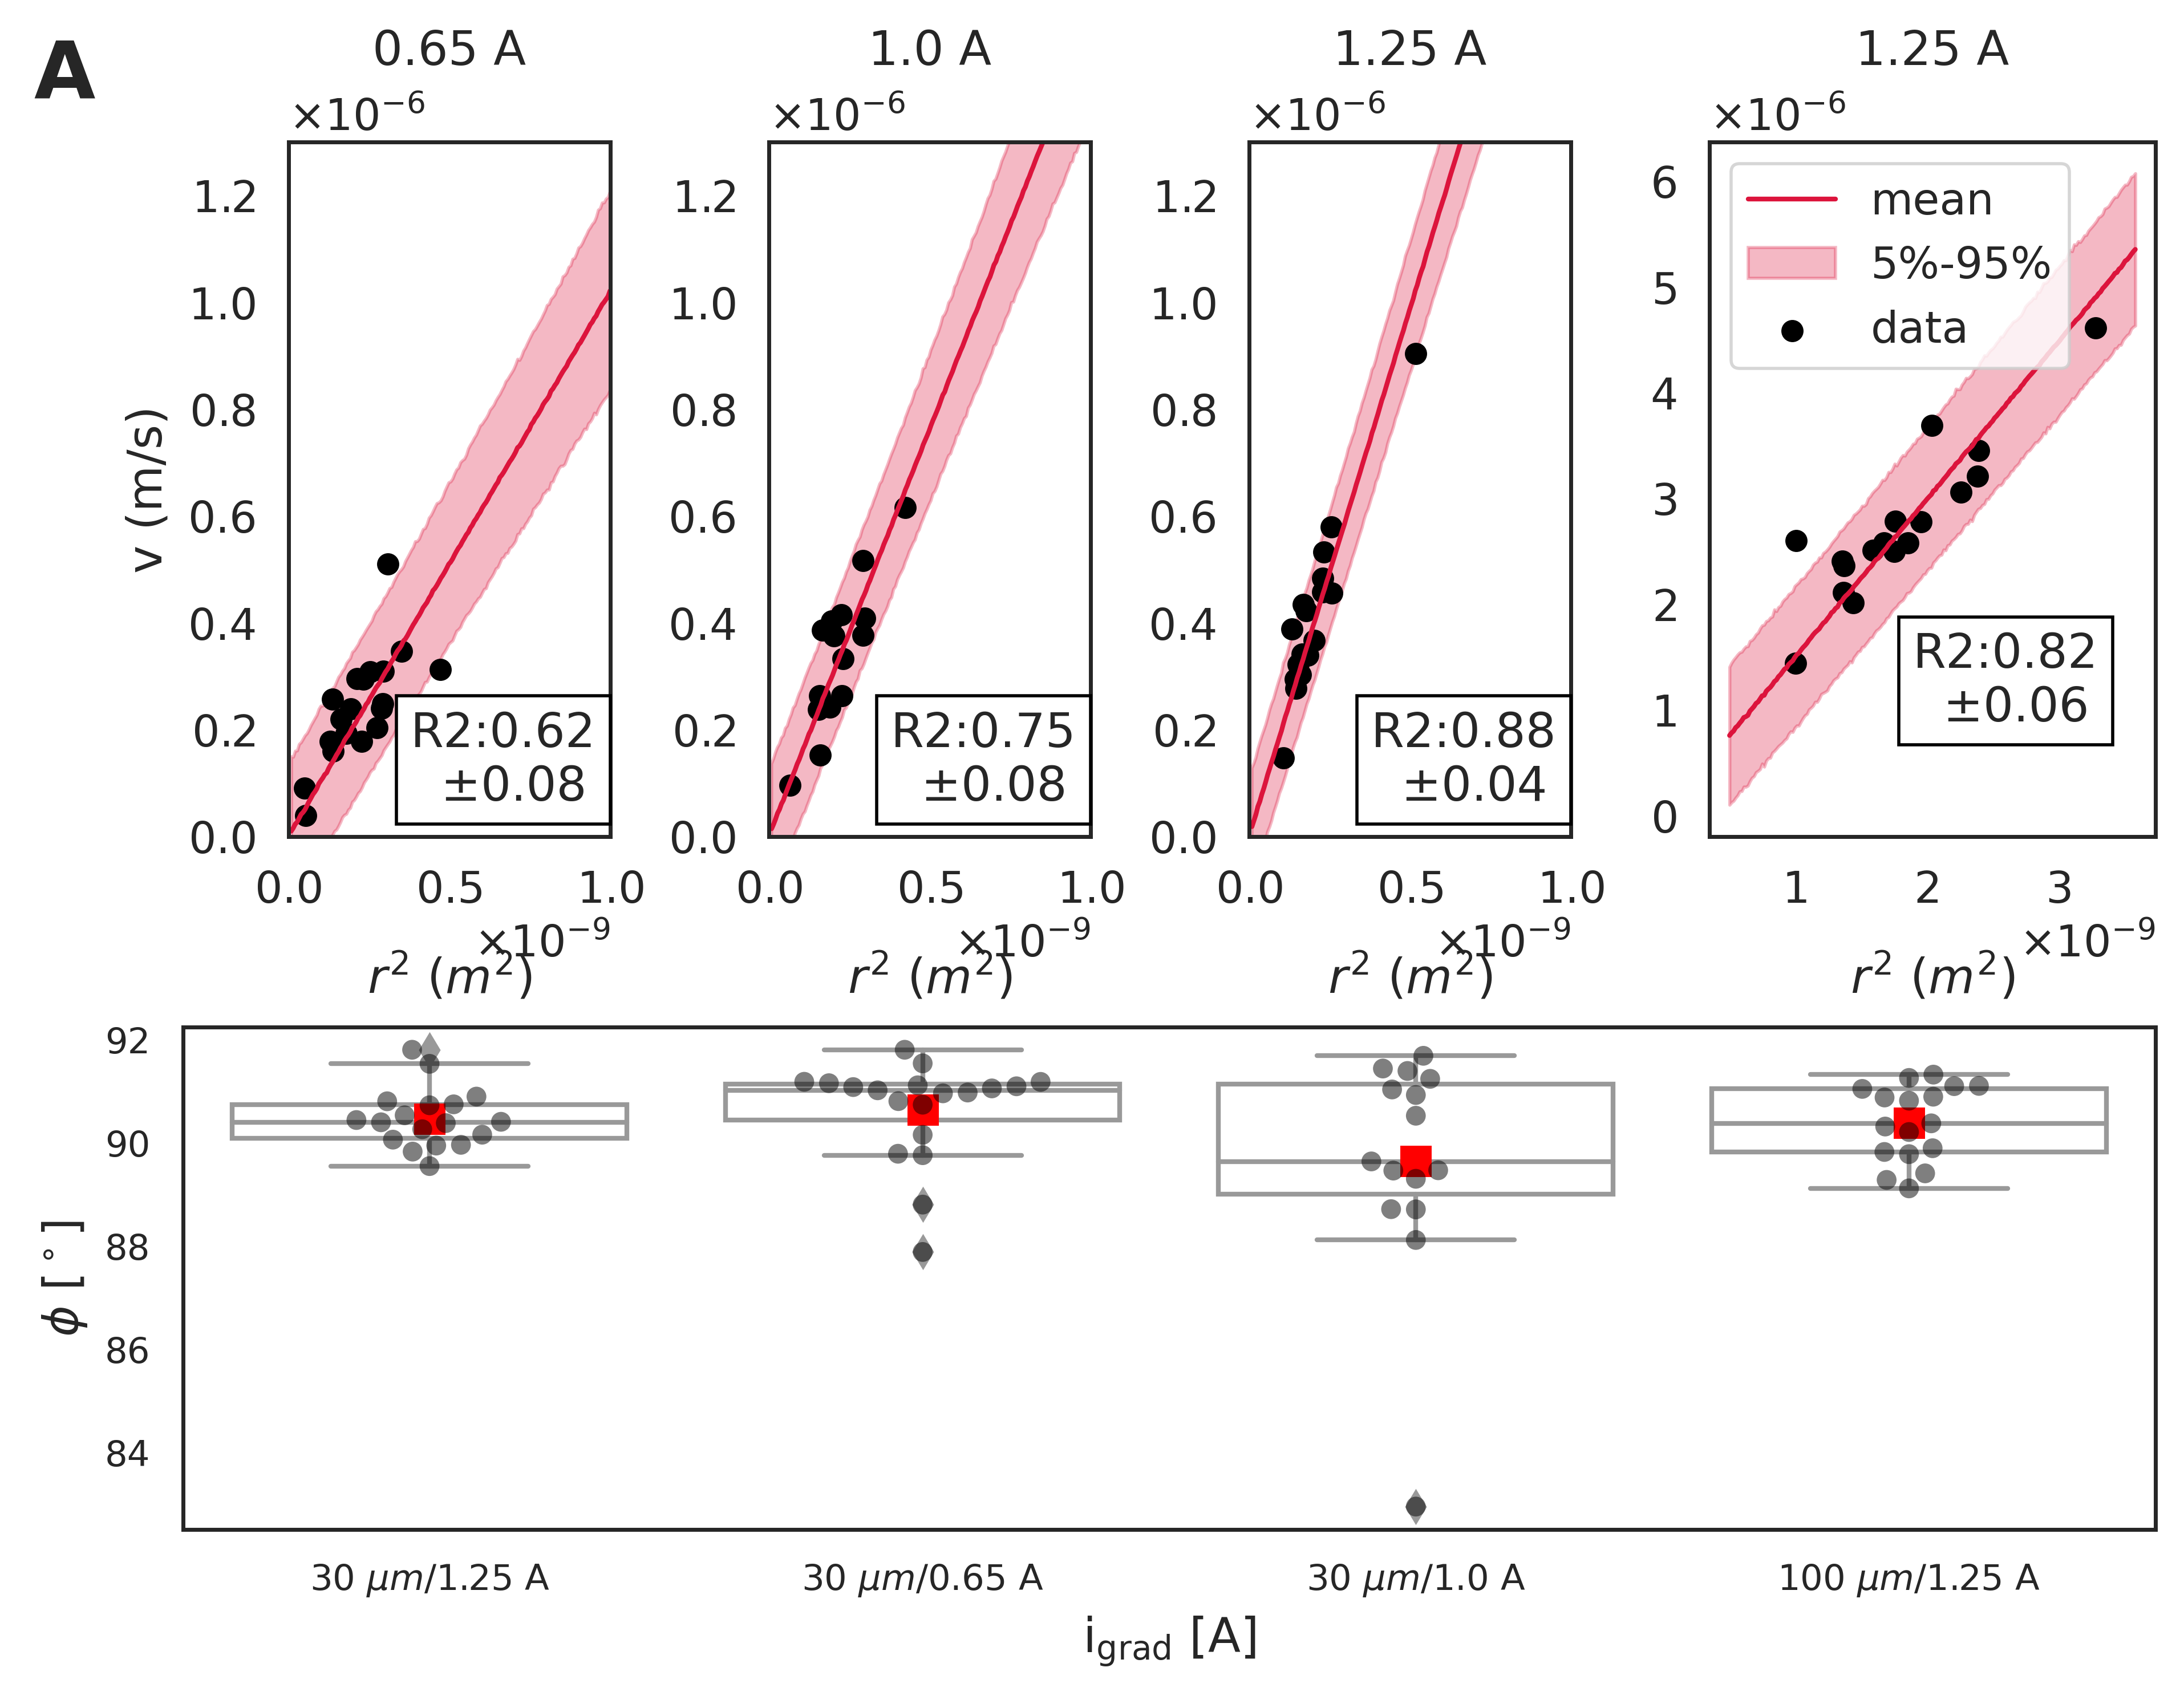

In [39]:
#fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
f_s = 20
fig = plt.figure(figsize=(7.5,8.75/1.5),constrained_layout=True,dpi=500)
subfigs = fig.subfigures(2, 1, wspace=0.0,hspace=0., height_ratios=[0.6, 0.4])
subfigs_nest = subfigs[0].subfigures(1, 2, width_ratios=[0.75, 0.25])
ax = subfigs_nest[0].subplots(1, 3,sharey=False)
ax_nest = subfigs_nest[1].subplots(1, 1,sharey=False)

currents = [0.65,1.00,1.25,1.26]
#ax = subfigs[0].subplots(1, 4,sharey=False)
#subfigs[0].suptitle(r'$v~\beta r^2$ for different currents')
def hats(hats,i,ra,move,ax):
    y_hats = hats.filter(regex='y_hat')
    up = np.percentile(y_hats,95,axis=0)
    down = np.percentile(y_hats,5,axis=0)
    mean = np.mean(y_hats,axis=0)
    ax[i].fill_between(ra,down,up,color='crimson',alpha=0.3,label='5%-95%')
    ax[i].plot(ra,mean,color='crimson',alpha=1.0,label='mean')
    ax[i].scatter(Xs[i],ys[i],color='black',label='data')
    ax[i].set_xlabel('$r^2$ ($m^2$)',labelpad=10)
    ax[i].set_title(f'{currents[i]} A\n')
    r2 = hats['r2'].values
    if not move:
        ax[i].text(0.38e-9,0.05e-6,f'R2:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',
                  bbox=dict(boxstyle="square",
                           ec=(0., 0., 0.),
                           fc=(1., 1., 1.)))

# r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]"
hats(y_hats_065,0,x_preds,False,ax)
hats(y_hats_100,1,x_preds,False,ax)
hats(y_hats_125,2,x_preds,False,ax)
hats(y_hats_big_man,-1,x_preds2,True,[ax_nest])
r2 = y_hats_big_man['r2'].values
ax_nest.text(1.9e-9,0.8e-6,f'R2:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',
          bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))
for i in range(3):
    ax[i].set_xlim([0,1.00e-9])
    ax[i].set_ylim([0,1.3e-6])
ax_nest.set_title('1.25 A' '\n')
ax[0].set_ylabel('v (m/s)')
ax_nest.legend(loc="upper left")

ax3 = subfigs[1].subplots(1, 1)
all_data['phi_(deg)'] = np.rad2deg(all_data['phi_(rad)'])
#sns.histplot(data=df[df['current']==1.25],x='F/V',ax=ax3,stat='density')
ax3 = plotter(all_data, "current_rename", "phi_(deg)","i$_\mathregular{grad}$ [A]",r"$\phi$ $[^\circ]$",ax3,"C",f_s=f_s)
#ax3.set_title(r"$\hat{F}_\mathregular{volumetric}$ for 1.25 A")
#ax3.set_xlabel(r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]")
#ax3.axvline(x=me-st,color='black',linewidth=1,linestyle='--')
#ax3.axvline(x=me+st,color='black',linewidth=1,linestyle='--')

ax[0].text(-0.6, 1.15, 'A', transform=ax[0].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
#ax2.text(-0.13, 1.15, 'B', transform=ax2.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
ax2.text(1, 1, 'B',fontsize=f_s, fontweight='bold', va='top', ha='right')

def to_sci(a):
    a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    a.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    a.yaxis.major.formatter._useMathText = True
    a.xaxis.major.formatter._useMathText = True

to_sci(ax[0])
to_sci(ax[1])
to_sci(ax[2])
to_sci(ax_nest)

#subfigs_nest[0].subplots_adjust(top=0.8, bottom=0.2, left=0.12, wspace=0.4)
#subfigs_nest[0].patch.set_linewidth(1)
#subfigs_nest[0].patch.set_edgecolor('cornflowerblue')

#subfigs[0].subplots_adjust(top=1.3, bottom=0.2, left=0.12, wspace=0.4)
#subfigs[0].patch.set_linewidth(1)
#subfigs[0].patch.set_edgecolor('cornflowerblue')

#subfigs_nest[0].suptitle(r'30 $\mu$m')
#subfigs_nest[1].suptitle(r'100 $\mu$m',y=1.)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.yaxis.major.formatter._useMathText = True
#fig.tight_layout(rect=[0, 0, 1., 1.3])
#fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/calib_slope.png'),dpi=500, format="png",bbox_inches="tight")
#fig.savefig(os.path.join('calibration.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})

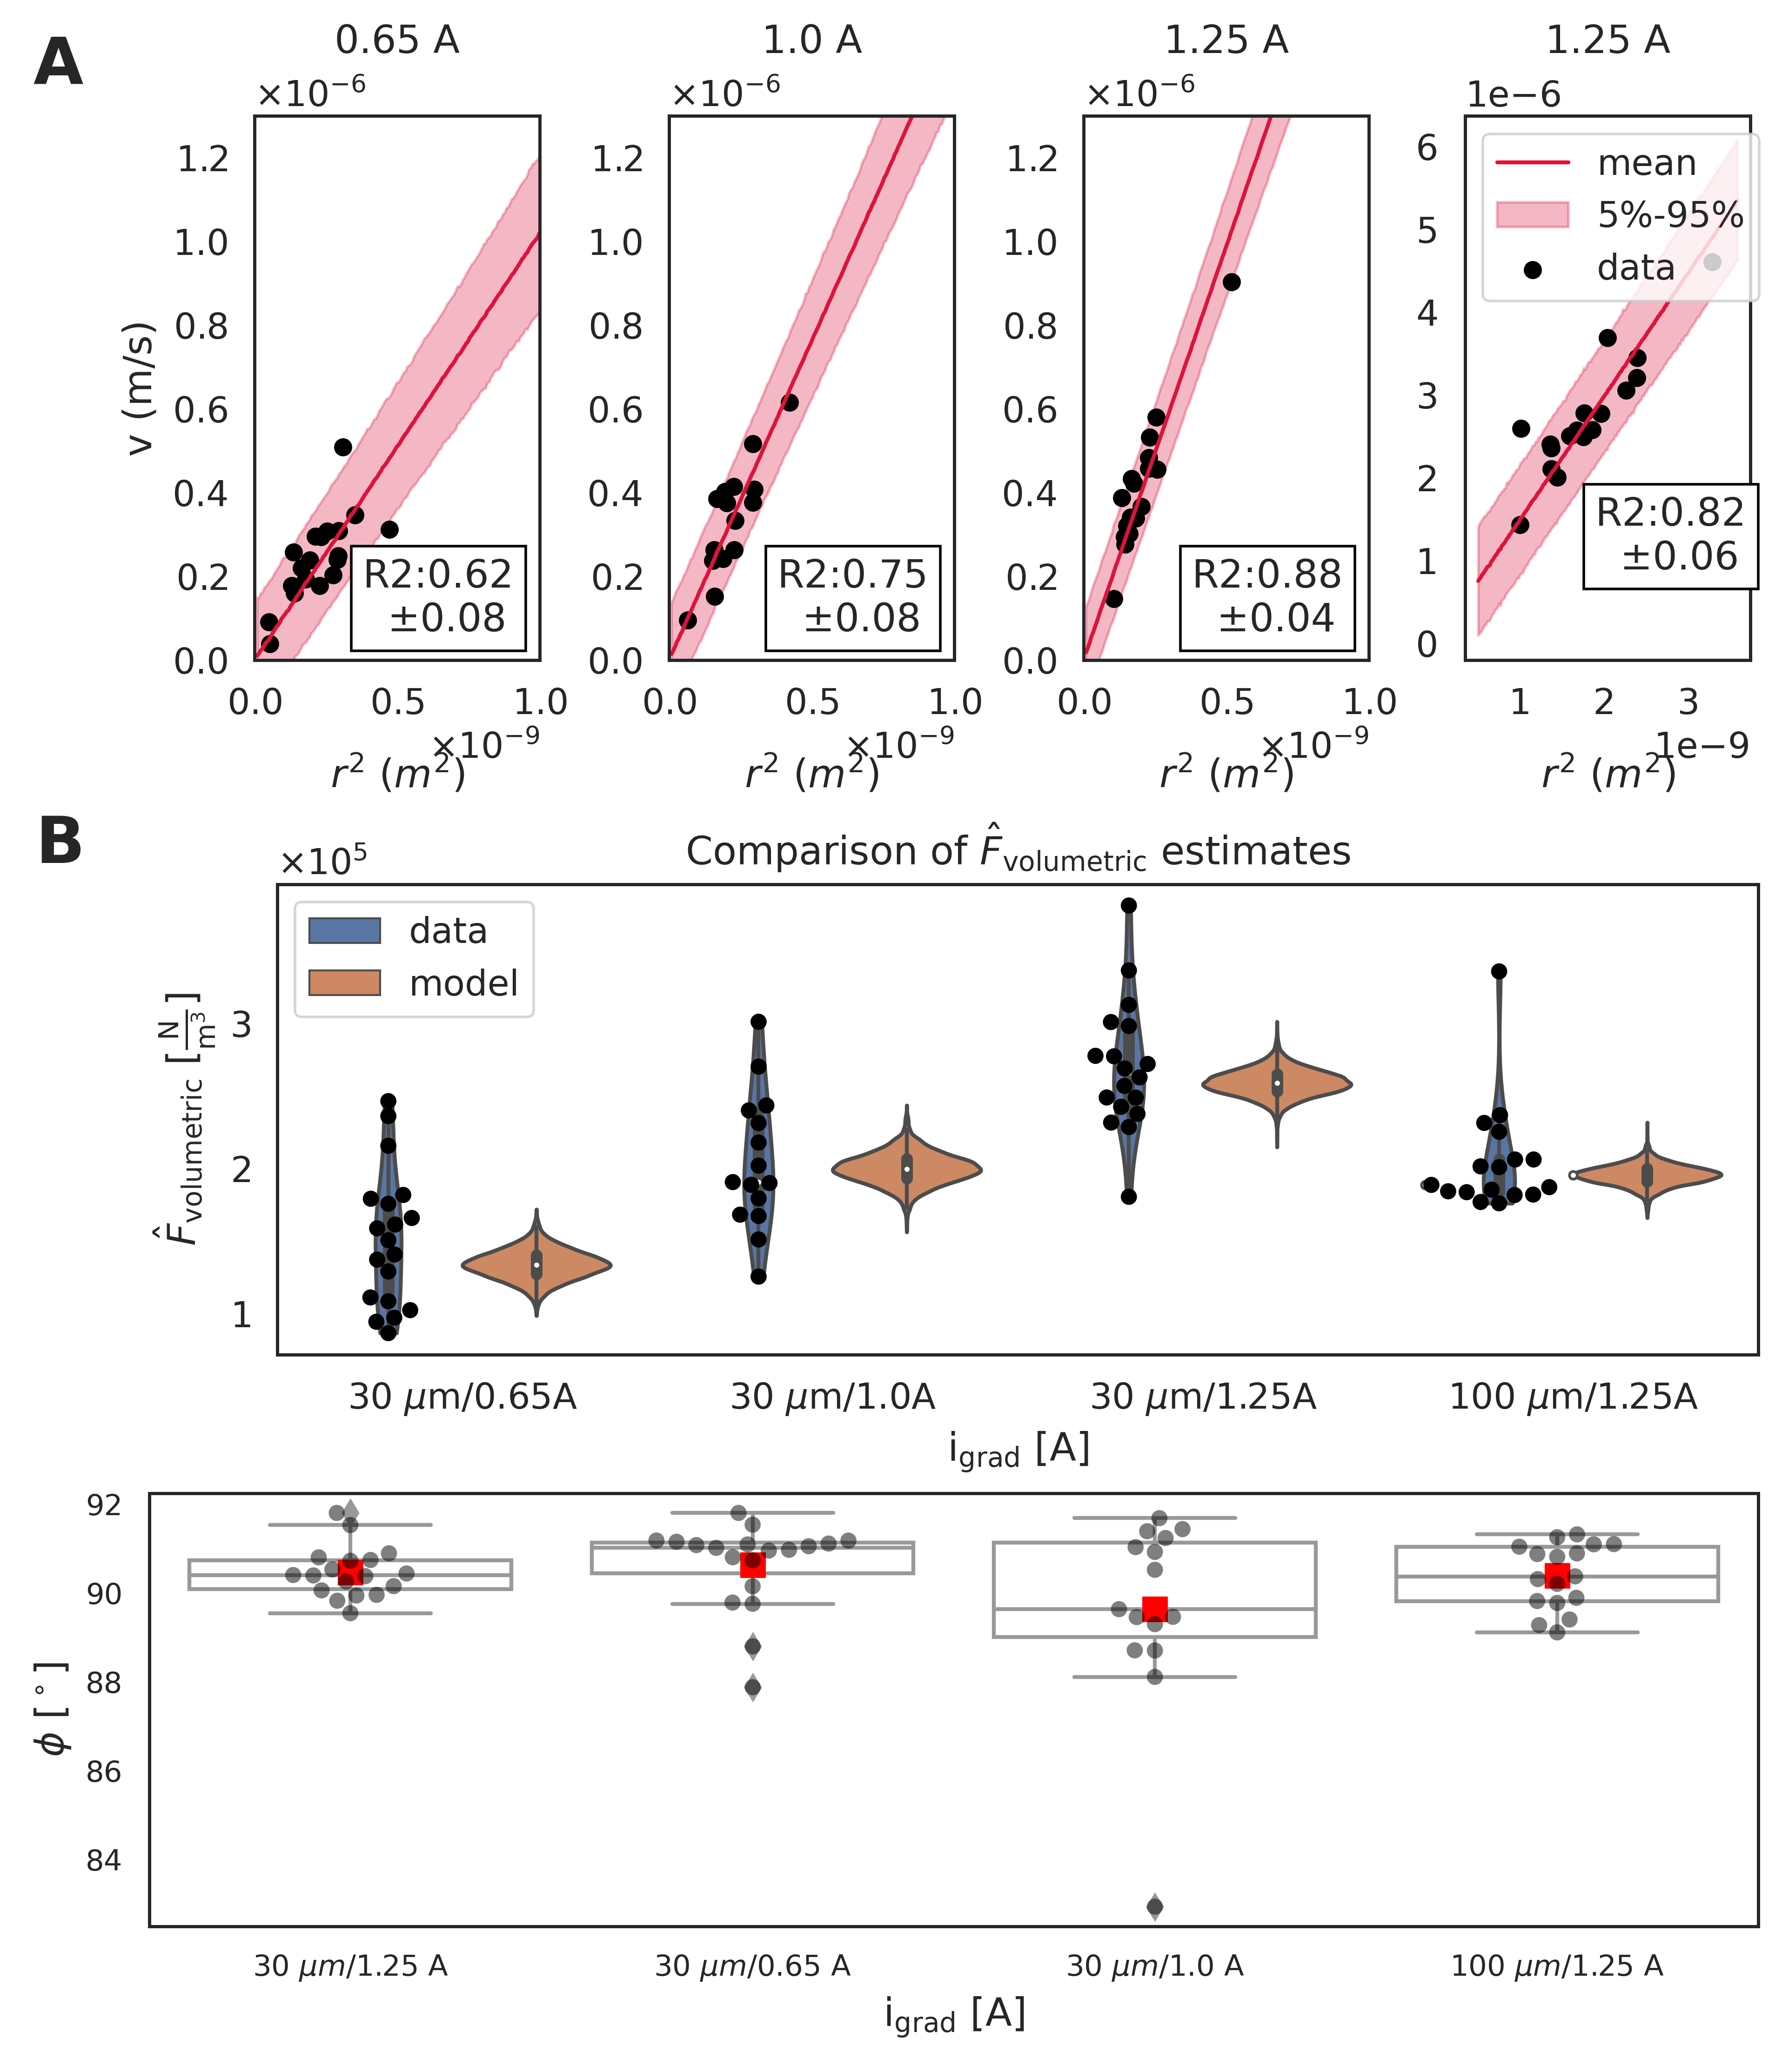

In [40]:
#fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
f_s = 20
fig = plt.figure(figsize=(7.5,8.75),constrained_layout=True,dpi=500)
subfigs = fig.subfigures(3, 1, wspace=0.0,hspace=0., height_ratios=[.35, 0.3,0.25])
ax = subfigs[0].subplots(1, 4,sharey=False)

currents = [0.65,1.00,1.25,1.26]
#ax = subfigs[0].subplots(1, 4,sharey=False)
#subfigs[0].suptitle(r'$v~\beta r^2$ for different currents')
def hats(hats,i,ra,move,ax):
    y_hats = hats.filter(regex='y_hat')
    up = np.percentile(y_hats,95,axis=0)
    down = np.percentile(y_hats,5,axis=0)
    mean = np.mean(y_hats,axis=0)
    ax[i].fill_between(ra,down,up,color='crimson',alpha=0.3,label='5%-95%')
    ax[i].plot(ra,mean,color='crimson',alpha=1.0,label='mean')
    ax[i].scatter(Xs[i],ys[i],color='black',label='data')
    ax[i].set_xlabel('$r^2$ ($m^2$)',labelpad=10)
    ax[i].set_title(f'{currents[i]} A\n')
    r2 = hats['r2'].values
    if not move:
        ax[i].text(0.38e-9,0.05e-6,f'R2:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',
                  bbox=dict(boxstyle="square",
                           ec=(0., 0., 0.),
                           fc=(1., 1., 1.)))

# r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]"
hats(y_hats_065,0,x_preds,False,ax)
hats(y_hats_100,1,x_preds,False,ax)
hats(y_hats_125,2,x_preds,False,ax)
hats(y_hats_big_man,-1,x_preds2,True,ax)
r2 = y_hats_big_man['r2'].values
ax[-1].text(1.9e-9,0.8e-6,f'R2:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',
          bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))
for i in range(3):
    ax[i].set_xlim([0,1.00e-9])
    ax[i].set_ylim([0,1.3e-6])
ax[-1].set_title('1.25 A' '\n')
ax[0].set_ylabel('v (m/s)')
ax[-1].legend(loc="upper left")
#plt.subplots_adjust(bottom=0.15)
ax2 = subfigs[1].subplots(1, 1)

orig_data = pd.DataFrame({
    'current':[*[r'30 $\mu$m/0.65A']*len(raws[0]),*[r'30 $\mu$m/1.0A']*len(raws[1]),*[r'30 $\mu$m/1.25A']*len(raws[2]),
              *[r'100 $\mu$m/1.25A']*len(raws[3])],
    'F/V':[*raws[0],*raws[1],*raws[2],*raws[3]],
    'estimate':'data'})
comb = pd.concat([orig_data,df])
sns.violinplot(data=comb,x='current',y='F/V',ax=ax2,hue='estimate',cut=0)
sns.swarmplot(data=orig_data,x='current',y='F/V',color='black',ax=ax2)
for item in ax2.collections[12:]:
    item.set_offsets(item.get_offsets() - 0.20)
ax2.set_xlabel("i$_\mathregular{grad}$ [A]")
ax2.set_title('Comparison of $\hat{F}_\mathregular{volumetric}$ estimates')
ax2.set_ylabel(r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]")
ax2.legend(loc='upper left')
ax3 = subfigs[2].subplots(1, 1)
all_data['phi_(deg)'] = np.rad2deg(all_data['phi_(rad)'])
#sns.histplot(data=df[df['current']==1.25],x='F/V',ax=ax3,stat='density')
ax3 = plotter(all_data, "current_rename", "phi_(deg)","i$_\mathregular{grad}$ [A]",r"$\phi$ $[^\circ]$",ax3,"C",f_s=f_s)
#ax3.set_title(r"$\hat{F}_\mathregular{volumetric}$ for 1.25 A")
#ax3.set_xlabel(r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]")
#ax3.axvline(x=me-st,color='black',linewidth=1,linestyle='--')
#ax3.axvline(x=me+st,color='black',linewidth=1,linestyle='--')

ax[0].text(-0.6, 1.15, 'A', transform=ax[0].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
ax2.text(-0.13, 1.15, 'B', transform=ax2.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
#ax3.text(-0.03, 1.15, 'C', transform=ax3.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')

def to_sci(a):
    a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    a.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    a.yaxis.major.formatter._useMathText = True
    a.xaxis.major.formatter._useMathText = True

to_sci(ax[0])
to_sci(ax[1])
to_sci(ax[2])
to_sci(ax_nest)

#subfigs_nest[0].suptitle(r'30 $\mu$m',y=1.3)
#subfigs_nest[1].suptitle(r'100 $\mu$m',y=1.3)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.yaxis.major.formatter._useMathText = True

#fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/calib_slope.png'),dpi=500, format="png",bbox_inches="tight")
#fig.savefig(os.path.join('calibration.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})

In [41]:
fv_1 = int(np.round(y1.mean())),int(np.round(y1.std()))
fv_2 = int(np.round(y2.mean())),int(np.round(y2.std()))
fv_3 = int(np.round(y3.mean())),int(np.round(y3.std()))
fv_4 = int(np.round(y4.mean())),int(np.round(y4.std()))

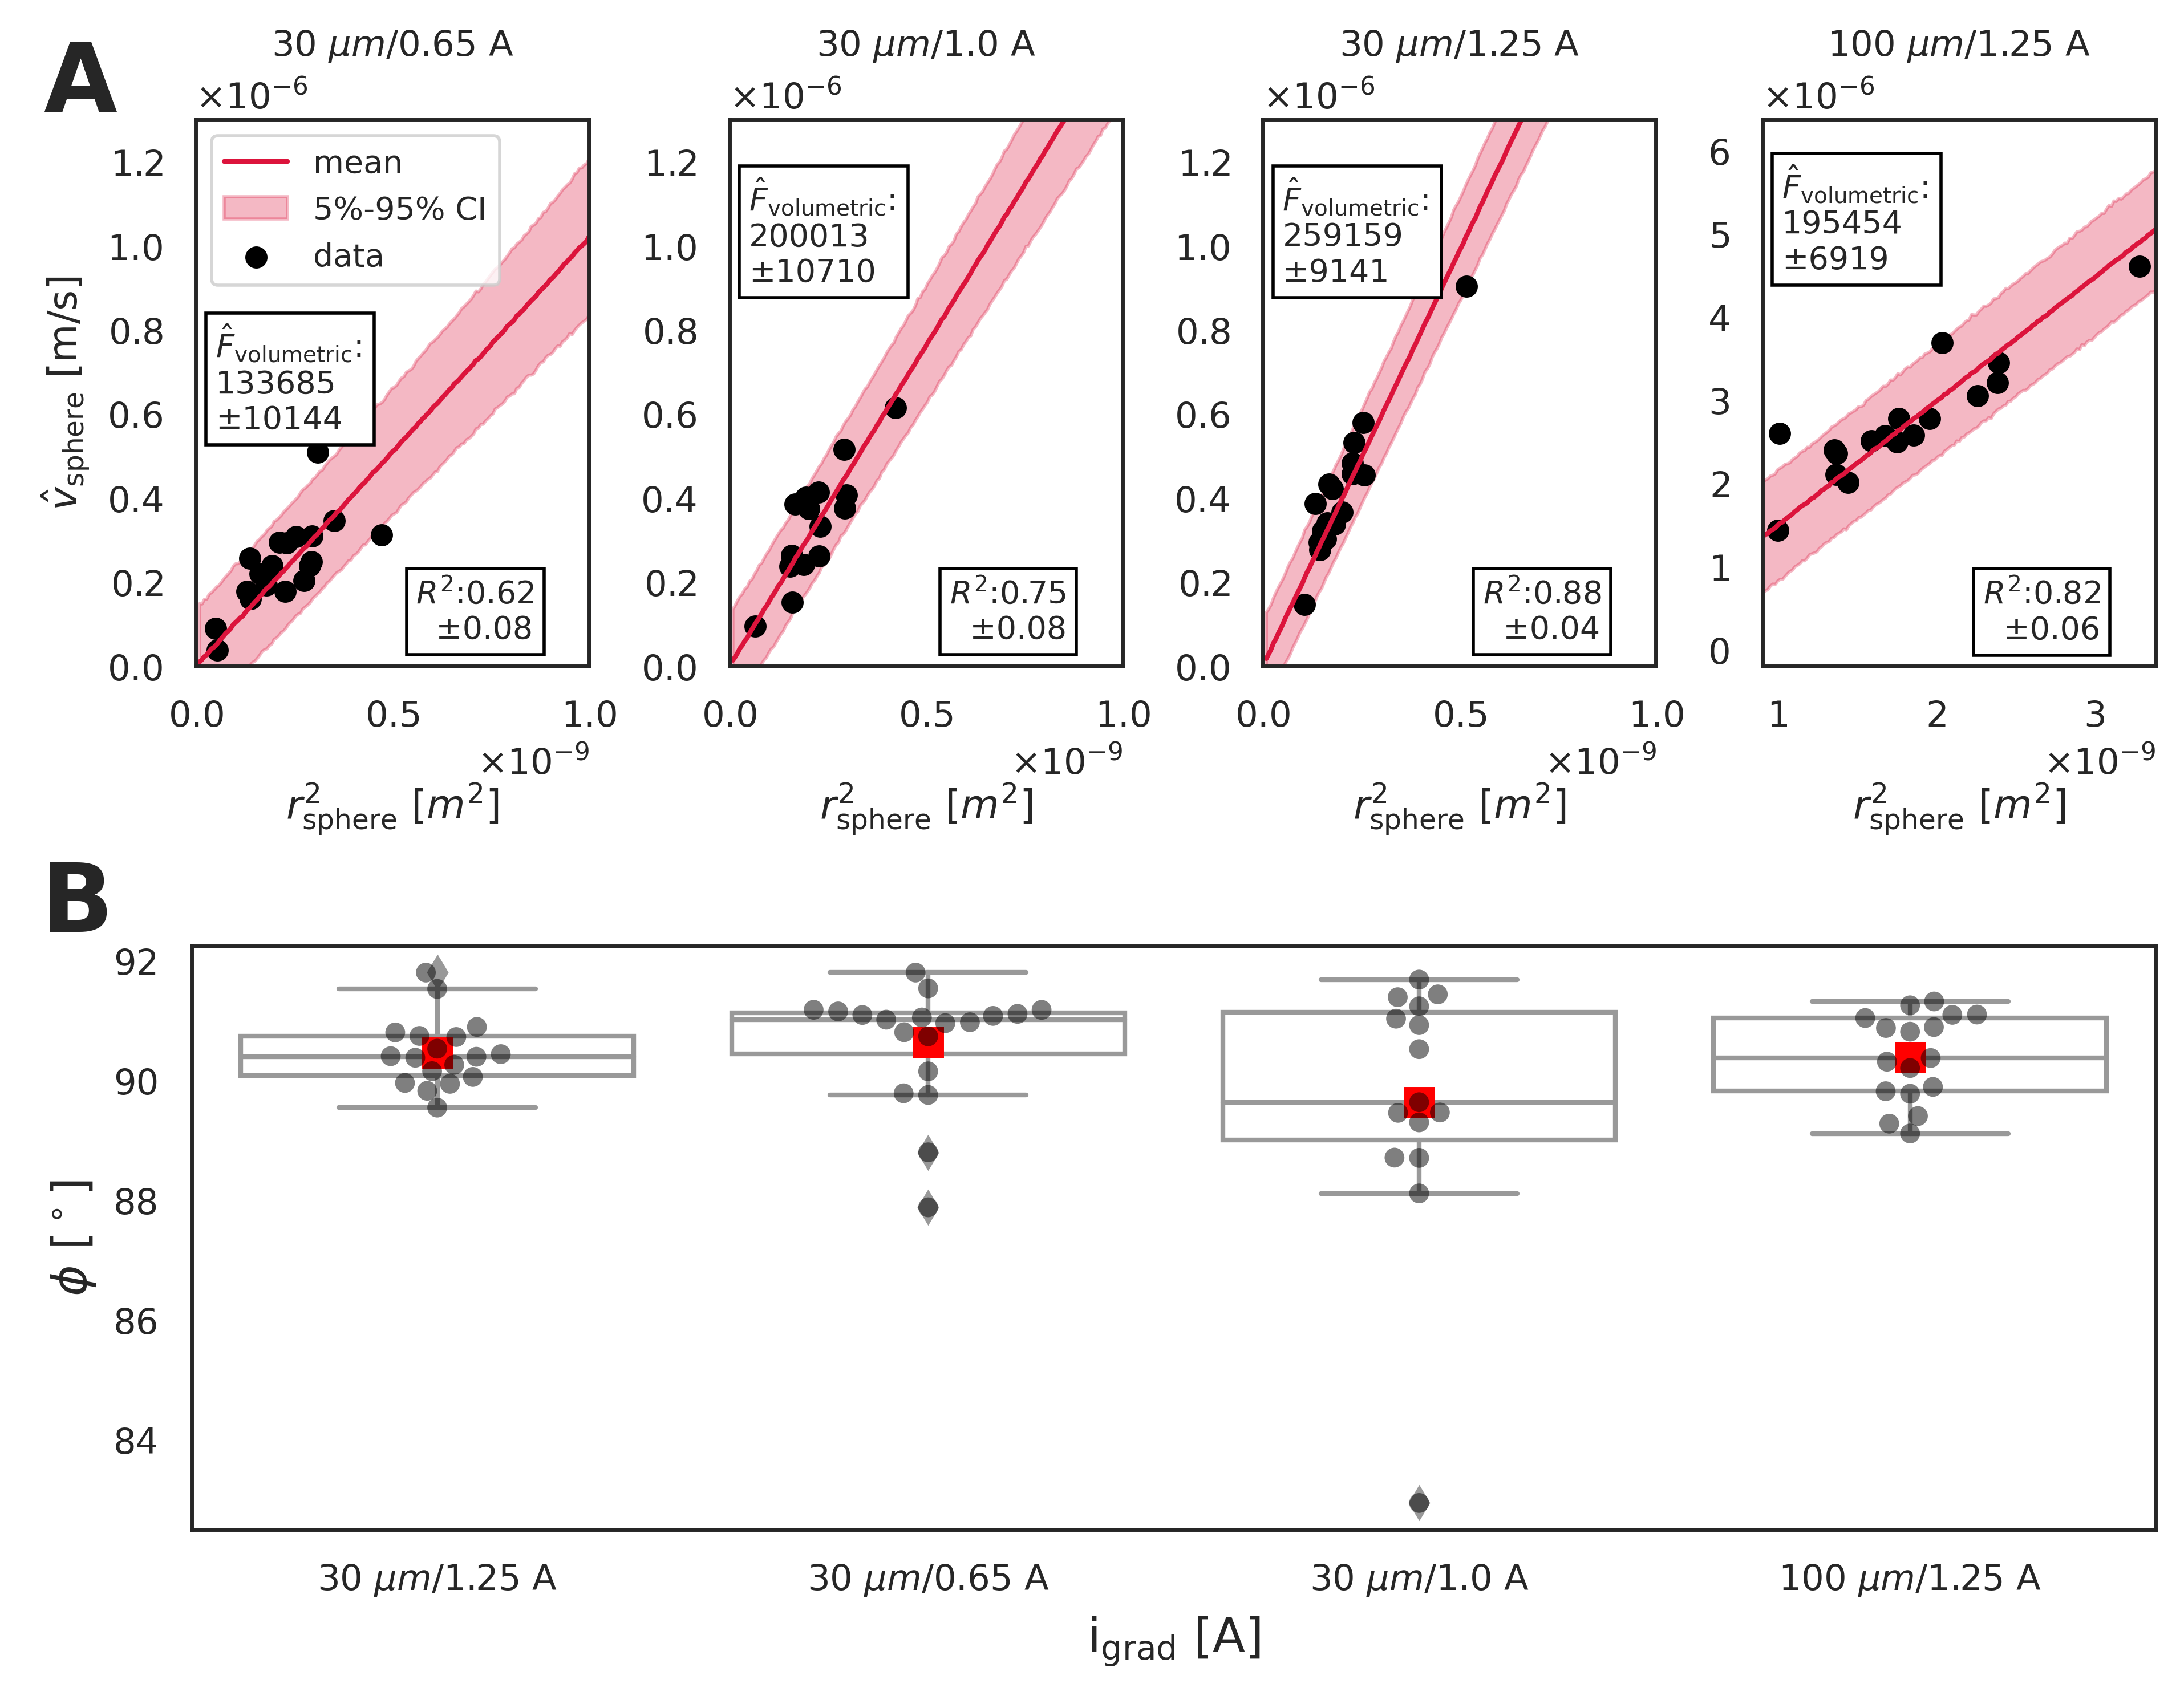

In [44]:
#fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
f_s = 16
f_s2 = 12
fig = plt.figure(figsize=(7.5,8.75/1.5),constrained_layout=True,dpi=500)
subfigs = fig.subfigures(2, 1, wspace=1.0,hspace=-2, height_ratios=[.5, .5])
ax = subfigs[0].subplots(1, 4,sharey=False)

currents = [0.65,1.00,1.25,1.26]
#ax = subfigs[0].subplots(1, 4,sharey=False)
#subfigs[0].suptitle(r'$v~\beta r^2$ for different currents')
def hats(hats,i,ra,move,ax):
    y_hats = hats.filter(regex='y_hat')
    up = np.percentile(y_hats,95,axis=0)
    down = np.percentile(y_hats,5,axis=0)
    mean = np.mean(y_hats,axis=0)
    ax[i].fill_between(ra,down,up,color='crimson',alpha=0.3,label='5%-95% CI')
    ax[i].plot(ra,mean,color='crimson',alpha=1.0,label='mean')
    ax[i].scatter(Xs[i],ys[i],color='black',label='data')
    ax[i].set_xlabel('$r^2_{\mathrm{sphere}}$ [$m^2$]',labelpad=12,fontsize=10)
    ax[i].set_title(r'30 $\mu m$/' f'{currents[i]} A\n',fontsize=9)
    r2 = hats['r2'].values
    if not move:
        ax[i].text(0.56e-9,0.05e-6,f'$R^2$:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',fontsize=8,
                  bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))

# r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]"
hats(y_hats_065,0,x_preds,False,ax)
hats(y_hats_100,1,x_preds,False,ax)
hats(y_hats_125,2,x_preds,False,ax)

ax[0].text(0.05e-9,0.55e-6,r'$\hat{F}_{\mathrm{volumetric}}$: ' f'\n{fv_1[0]}\n±{fv_1[1]}',va='bottom',fontsize=8,
          bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))
ax[1].text(0.05e-9,0.9e-6,r'$\hat{F}_{\mathrm{volumetric}}$: ' f'\n{fv_2[0]}\n±{fv_2[1]}',va='bottom',fontsize=8,
          bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))
ax[2].text(0.05e-9,0.9e-6,r'$\hat{F}_{\mathrm{volumetric}}$: ' f'\n{fv_3[0]}\n±{fv_3[1]}',va='bottom',fontsize=8,
          bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))

hats(y_hats_big_man,-1,x_preds2,True,ax)
ax[3].text(1.03e-9,4.5e-6,r'$\hat{F}_{\mathrm{volumetric}}$: ' f'\n{fv_4[0]}\n±{fv_4[1]}',va='bottom',fontsize=8,
          bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))
r2 = y_hats_big_man['r2'].values
ax[-1].text(2.3e-9,0.05e-6,f'$R^2$:{np.round(r2.mean(),2)}\n  ±{np.round(r2.std(),2)}',va='bottom',fontsize=8,
           bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.)))
#ax[-1].set_ylim(0,5e-6)
ax[-1].set_xlim([Xs[-1].min()-0.1e-9,Xs[-1].max()+0.1e-9])
for i in range(3):
    ax[i].set_xlim([0,1.00e-9])
    ax[i].set_ylim([0,1.3e-6])
ax[-1].set_title(r'100 $\mu m$/1.25 A' '\n',fontsize=9)
ax[0].set_ylabel(r'$\hat{v}_{\mathrm{sphere}}$ [m/s]',fontsize=10)
ax[0].legend(loc="upper left",fontsize=8)

ax3 = subfigs[1].subplots(1, 1)
all_data['phi_(deg)'] = np.rad2deg(all_data['phi_(rad)'])
#sns.histplot(data=df[df['current']==1.25],x='F/V',ax=ax3,stat='density')
ax3 = plotter(all_data, "current_rename", "phi_(deg)","i$_\mathregular{grad}$ [A]",r"$\phi$ $[^\circ]$",ax3,"B",f_s=24)


ax[0].text(-0.2, 1.15, 'A', transform=ax[0].transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
ax3.text(-0.04, 1.15, 'B', transform=ax3.transAxes,fontsize=24, fontweight='bold', va='top', ha='right')
def to_sci(a):
    a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    a.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    a.yaxis.major.formatter._useMathText = True
    a.xaxis.major.formatter._useMathText = True

to_sci(ax[0])
to_sci(ax[1])
to_sci(ax[2])
to_sci(ax[3])
for i in ax:
    i.tick_params(labelsize=9)
    i.yaxis.get_offset_text().set_fontsize(9)
    i.xaxis.get_offset_text().set_fontsize(9)

#subfigs[0].subplots_adjust(wspace=0.3)
#subfigs[1].subplots_adjust(top=0.3)
    
#fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/calib_slope.png'),dpi=500, format="png",bbox_inches="tight")
#fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/Fig_3.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})

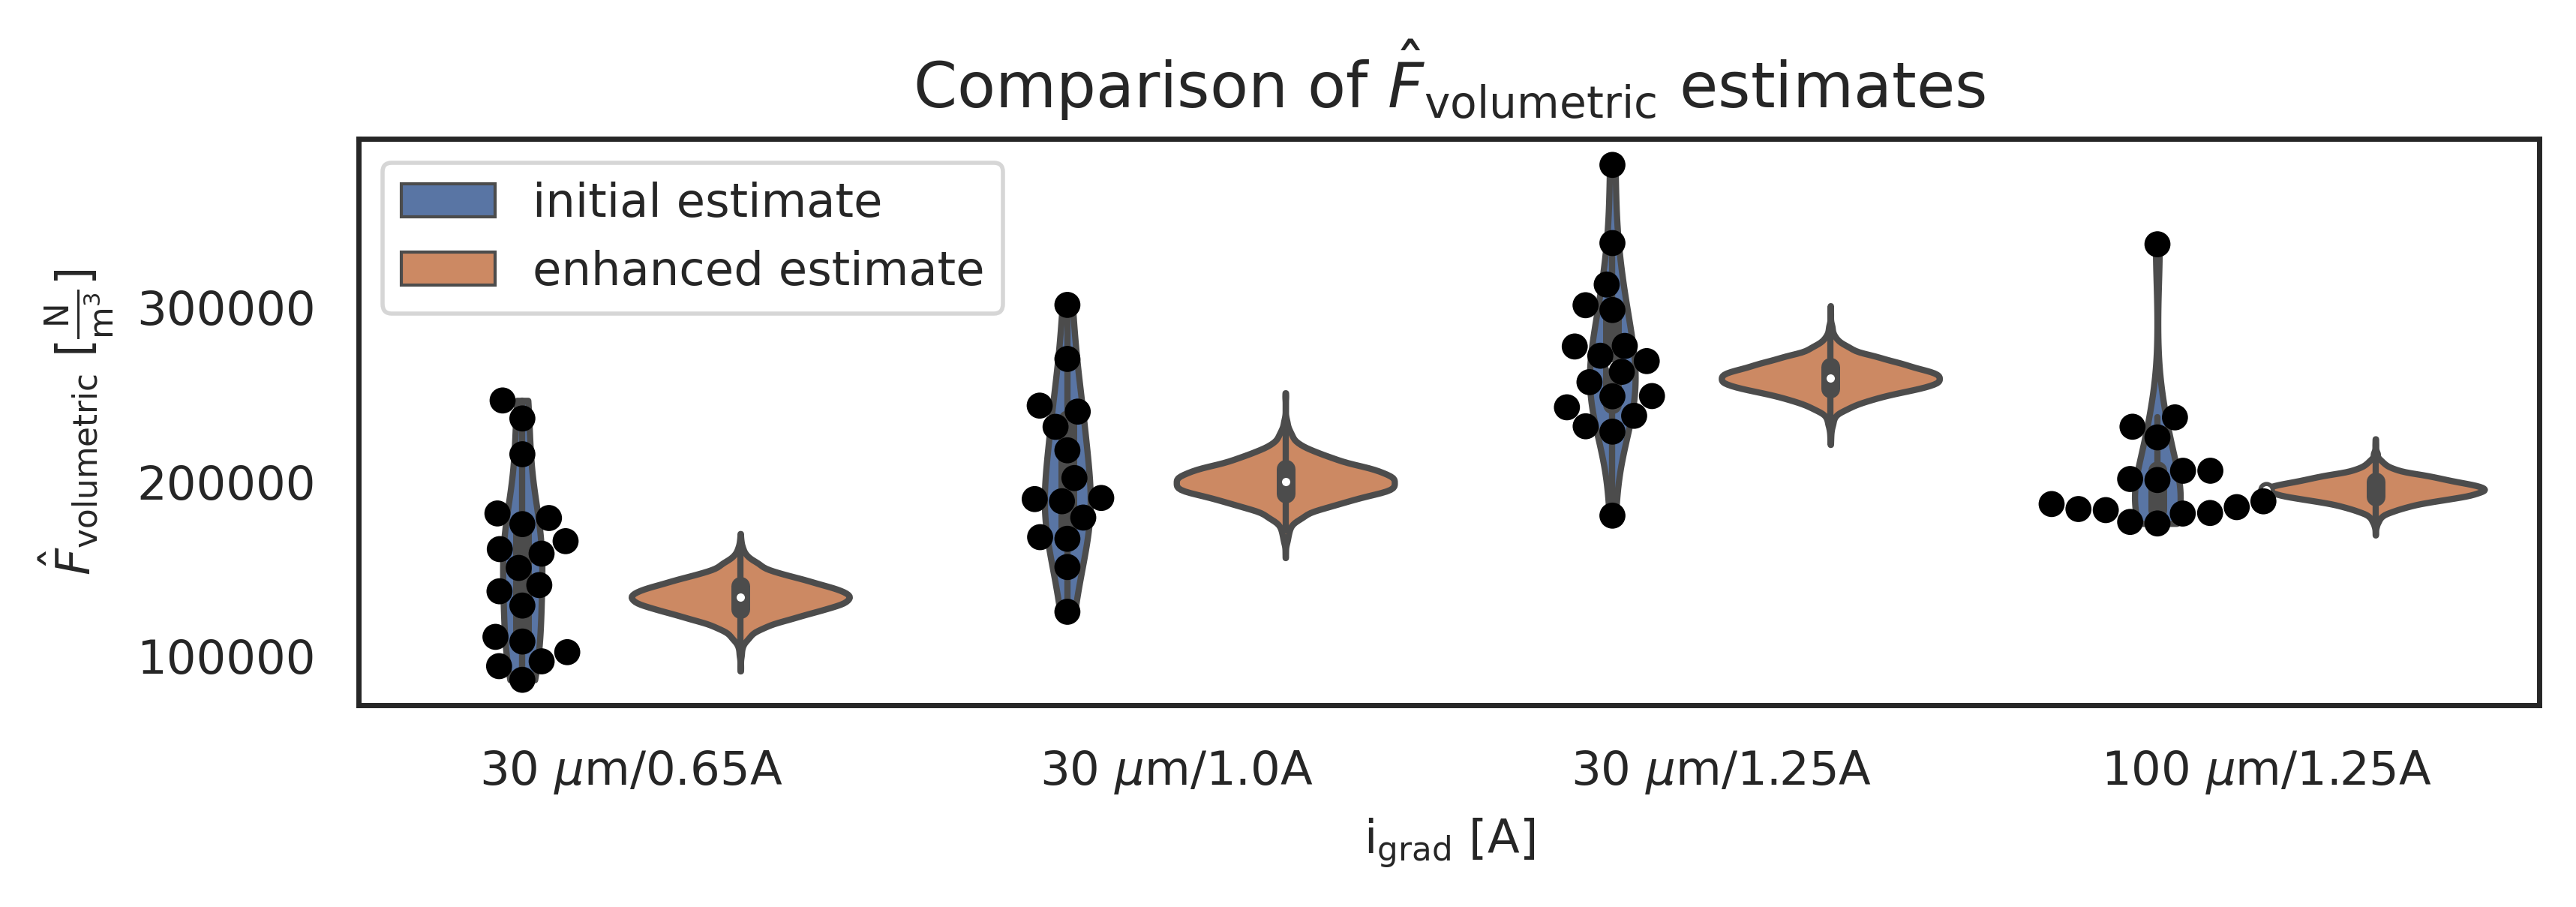

In [45]:
fig,ax = plt.subplots(1,1,figsize=(7.5,2),dpi=500)
orig_data = pd.DataFrame({
    'current':[*[r'30 $\mu$m/0.65A']*len(raws[0]),*[r'30 $\mu$m/1.0A']*len(raws[1]),*[r'30 $\mu$m/1.25A']*len(raws[2]),
              *[r'100 $\mu$m/1.25A']*len(raws[3])],
    'F/V':[*raws[0],*raws[1],*raws[2],*raws[3]],
    'estimate':'initial estimate'})
comb = pd.concat([orig_data,df])
comb.loc[comb['estimate']=='model','estimate'] = 'enhanced estimate'
sns.violinplot(data=comb,x='current',y='F/V',ax=ax,hue='estimate',cut=0)
sns.swarmplot(data=orig_data,x='current',y='F/V',color='black',ax=ax)
for item in ax.collections[12:]:
    item.set_offsets(item.get_offsets() - 0.20)
ax.set_xlabel("i$_\mathregular{grad}$ [A]",fontsize=9)
ax.set_title('Comparison of $\hat{F}_\mathregular{volumetric}$ estimates',fontsize=12)
ax.set_ylabel(r"$\hat{F}_\mathregular{volumetric}$ [$\frac{\rm{N}}{\rm{m}^3}$]",fontsize=9)
ax.legend(loc='upper left',fontsize=9)


ax.tick_params(labelsize=9)
ax.yaxis.get_offset_text().set_fontsize(9)
ax.xaxis.get_offset_text().set_fontsize(9)

fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/fv_comparison.png'),dpi=500, format="png",bbox_inches="tight")
fig.savefig(os.path.join('/mnt/c/Users/pokkilab/Pictures/Fig_3.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})